# Dataset ARPAE
Registrazione delle misure recuperate dal database di ARPA Emilia-Romagna.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [47]:
dataset_id <- "ARPAE" 
state <- "Emilia-Romagna"


In [48]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
theme_set(theme_dark())
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [16]:
daily_dataset <- load_daily_data.arpae() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1862632,99.5,3439398,183.7,NA,3439398,183.7
Vcells,16058136,122.6,43059639,328.6,16384,42504847,324.3


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [17]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1970645,105.3,3439398,183.7,NA,3439398,183.7
Vcells,16128023,123.1,57565372,439.2,16384,71956118,549.0


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

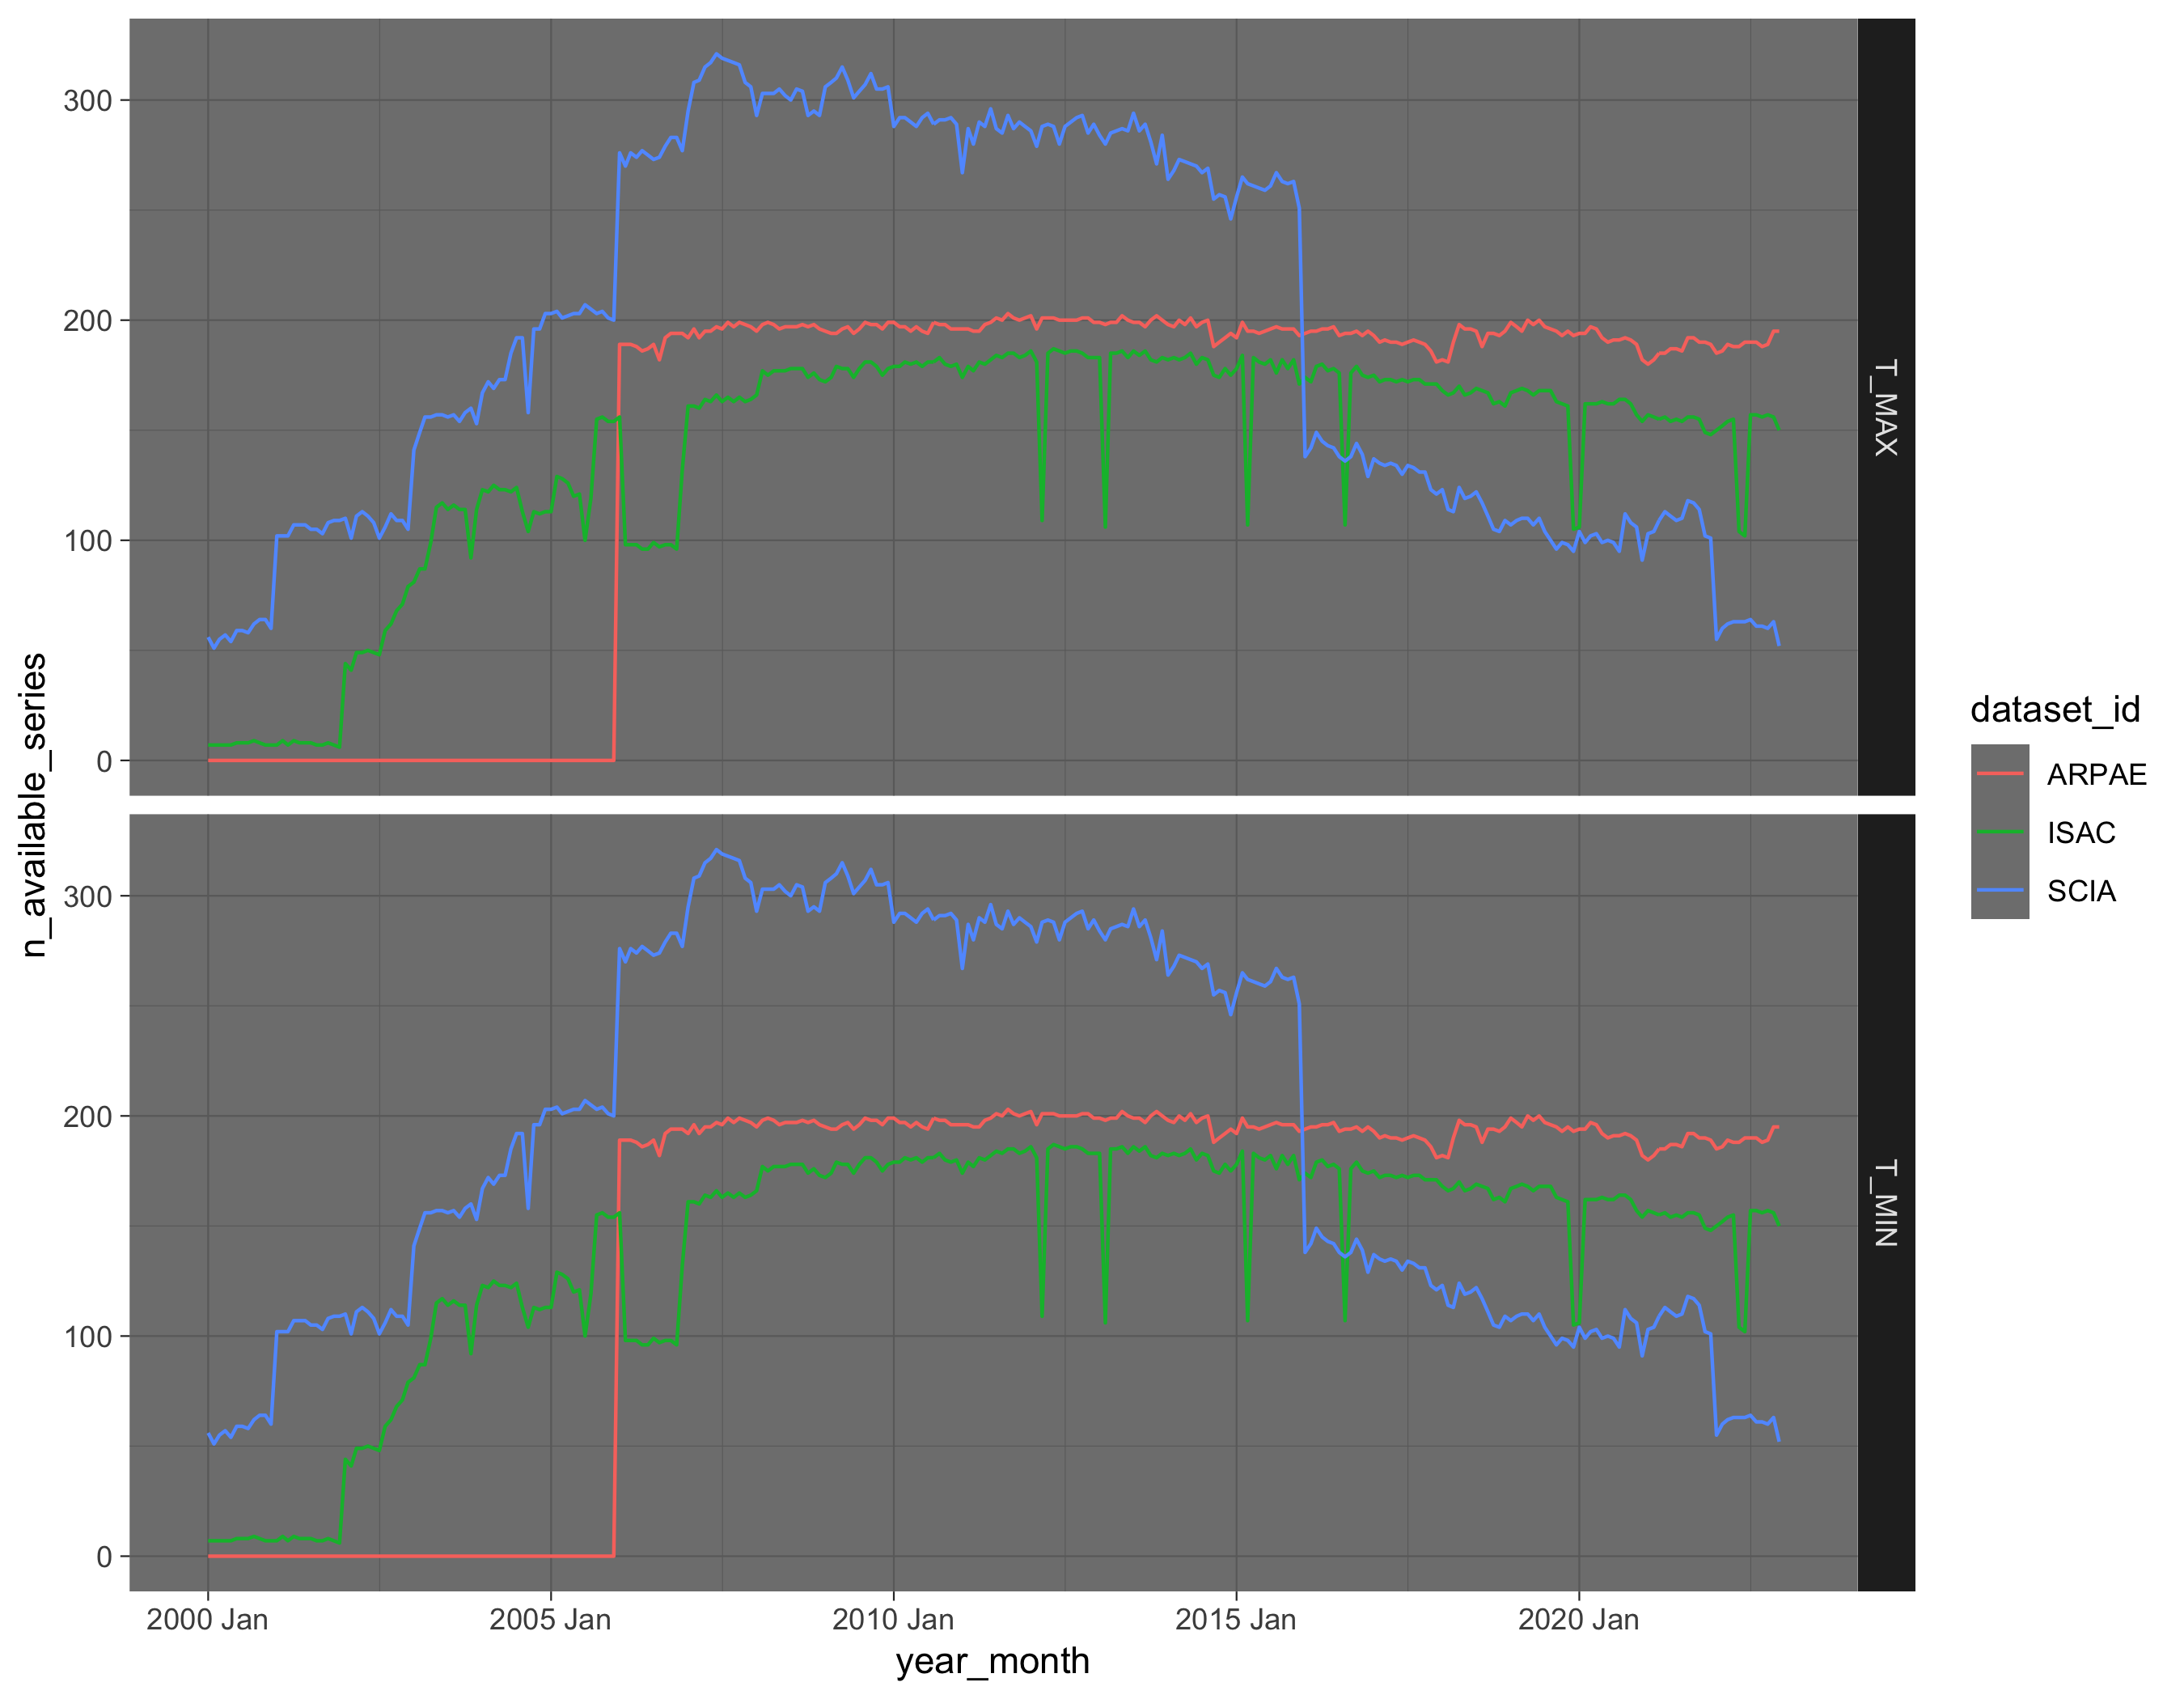

In [29]:
qc_database <- open_checkpoint(dataset_id, "qc1")
others <- concat_databases(
    open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries),
    open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries)
)
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = others,
    start_date = first_date,
    end_date = last_date
)
p


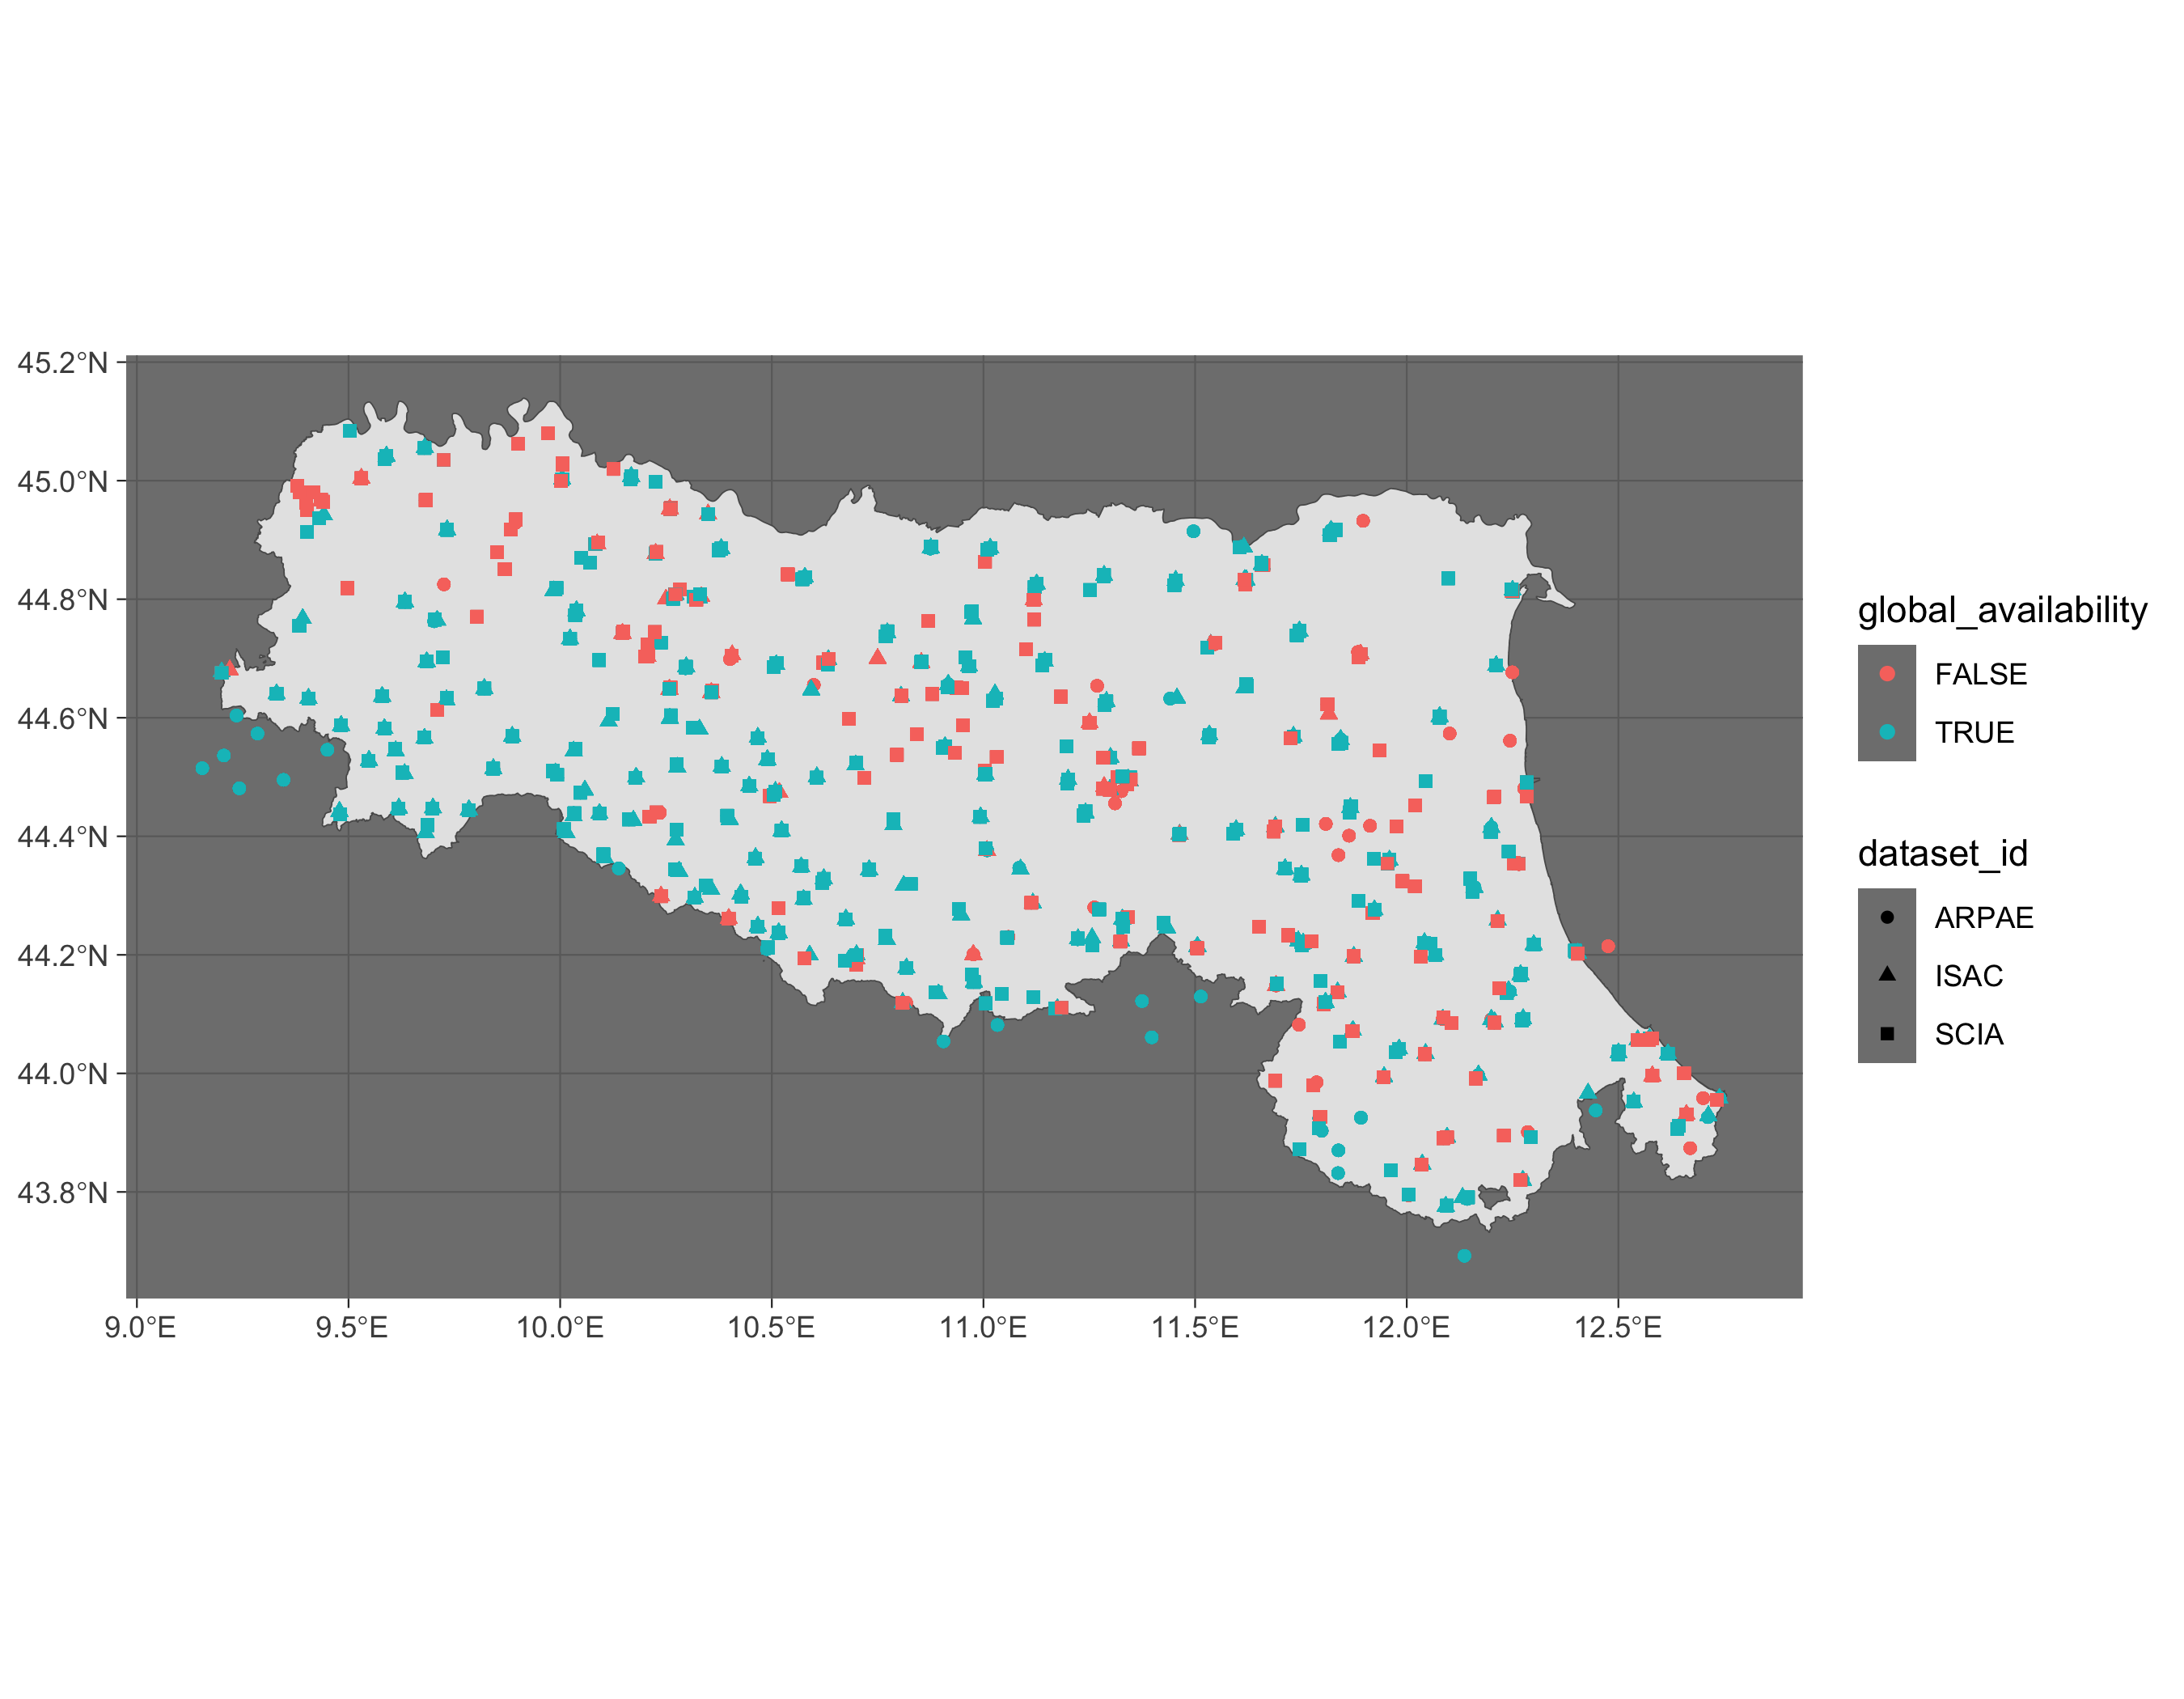

In [30]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, concat_tables(qc_database$meta, others$meta), state_boundaries)
p


In [31]:
rm(qc_database)
rm(ymonthly_avail)
rm(others)
rm(climats)
rm(p)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2368665,126.6,6227121,332.6,NA,6227121,332.6
Vcells,28639809,218.6,386261510,2947.0,16384,523709723,3995.6


## Merging
Gap-filling con altri dataset. Da analisi preliminare risulta che $|\mathrm{T_{ARPA}}| \ge |\mathrm{T_{ISAC}}|$ e $|\mathrm{T_{ARPA}}| \approx |\mathrm{T_{SCIA}}|$. Farò prima il match con SCIA.

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [26]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries |> sf::st_buffer(dist = units::set_units(2, "km")))
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = 8,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_state)
rm(qc_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2367766,126.5,6227121,332.6,NA,6227121,332.6
Vcells,28682481,218.9,335174228,2557.2,16384,523709723,3995.6


In [35]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,607
FALSE,TRUE,974
TRUE,FALSE,695
TRUE,TRUE,20


station_id.x,n
<chr>,<int>
0b0542cf8e2cb7fa67b9aaaa5fa4d38b,6
12746b430002d5eb6e5cbbdfb71e23be,6
27d5d22cebca120b1ecbf748ceb1e817,8
27f4a4eefe3414f7363155c7ad1f1a98,6
2eb79b9da5f28432e57ba8a38bf5a132,8
2f54c5bef72df821dbd0cf5f6e3d2b29,6
3066f0597cc43bf0551936c45cb2320c,6
4c8351a067dc9a31f2381328107ebf51,6
51e4e6165fd45d47954f836ef9b9fdef,8


station_id.y,n
<chr>,<int>
0115f662f17b26d7b9f3ea8375c0345f,4
0ecc23fcceb676026750a51b24a87770,4
1f1055e7c4af16eeda0bd5eb80132b39,4
2fc401f6e856de35be2fb8c29645b2e0,4
477376e730bc19c2ddcf271431905bc1,4
4aa20a569b521d89a5755a335d9f1d7d,4
4c124bdab4ca3161450c9cf3c84e028e,3
788b696737e946e488300b2d97fce461,4
95f5004269088bccf9f7d5f0d13a11e5,4


In [37]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1.5, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "scia_merged")
save_match_list(combination_results$match_list, dataset_id, "scia_merged")


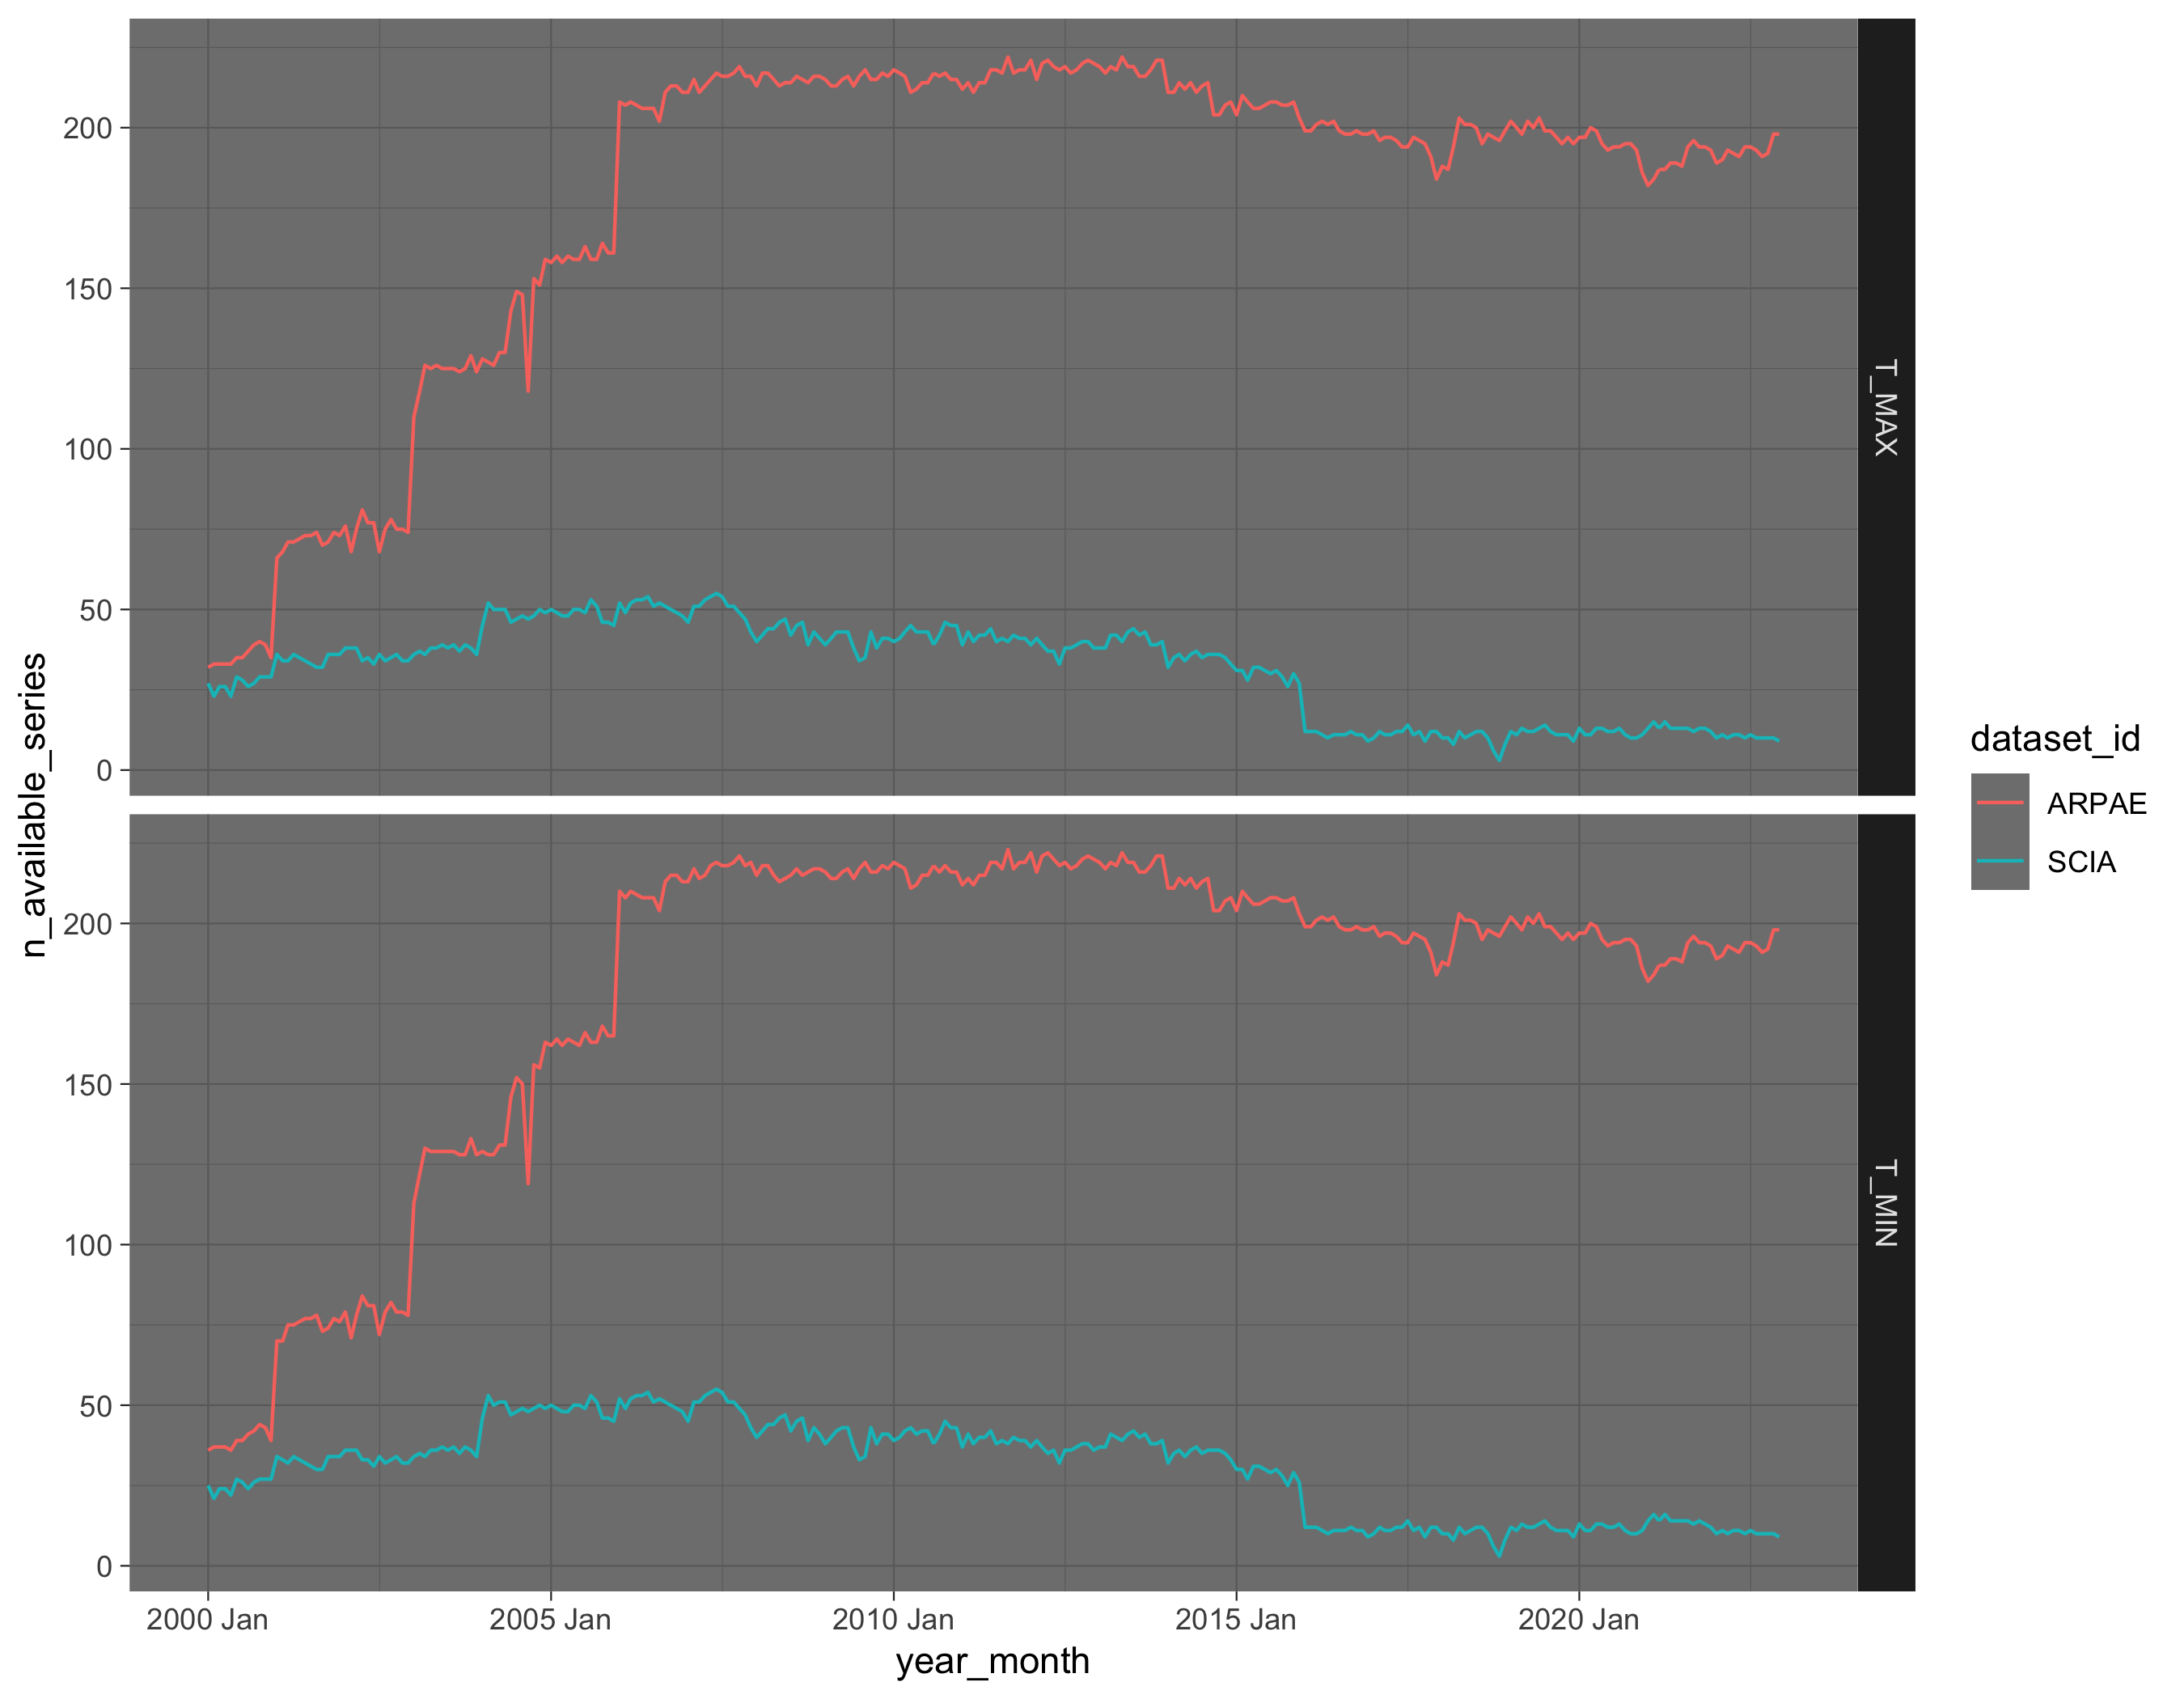

In [38]:
combined_database <- open_checkpoint(dataset_id, "scia_merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


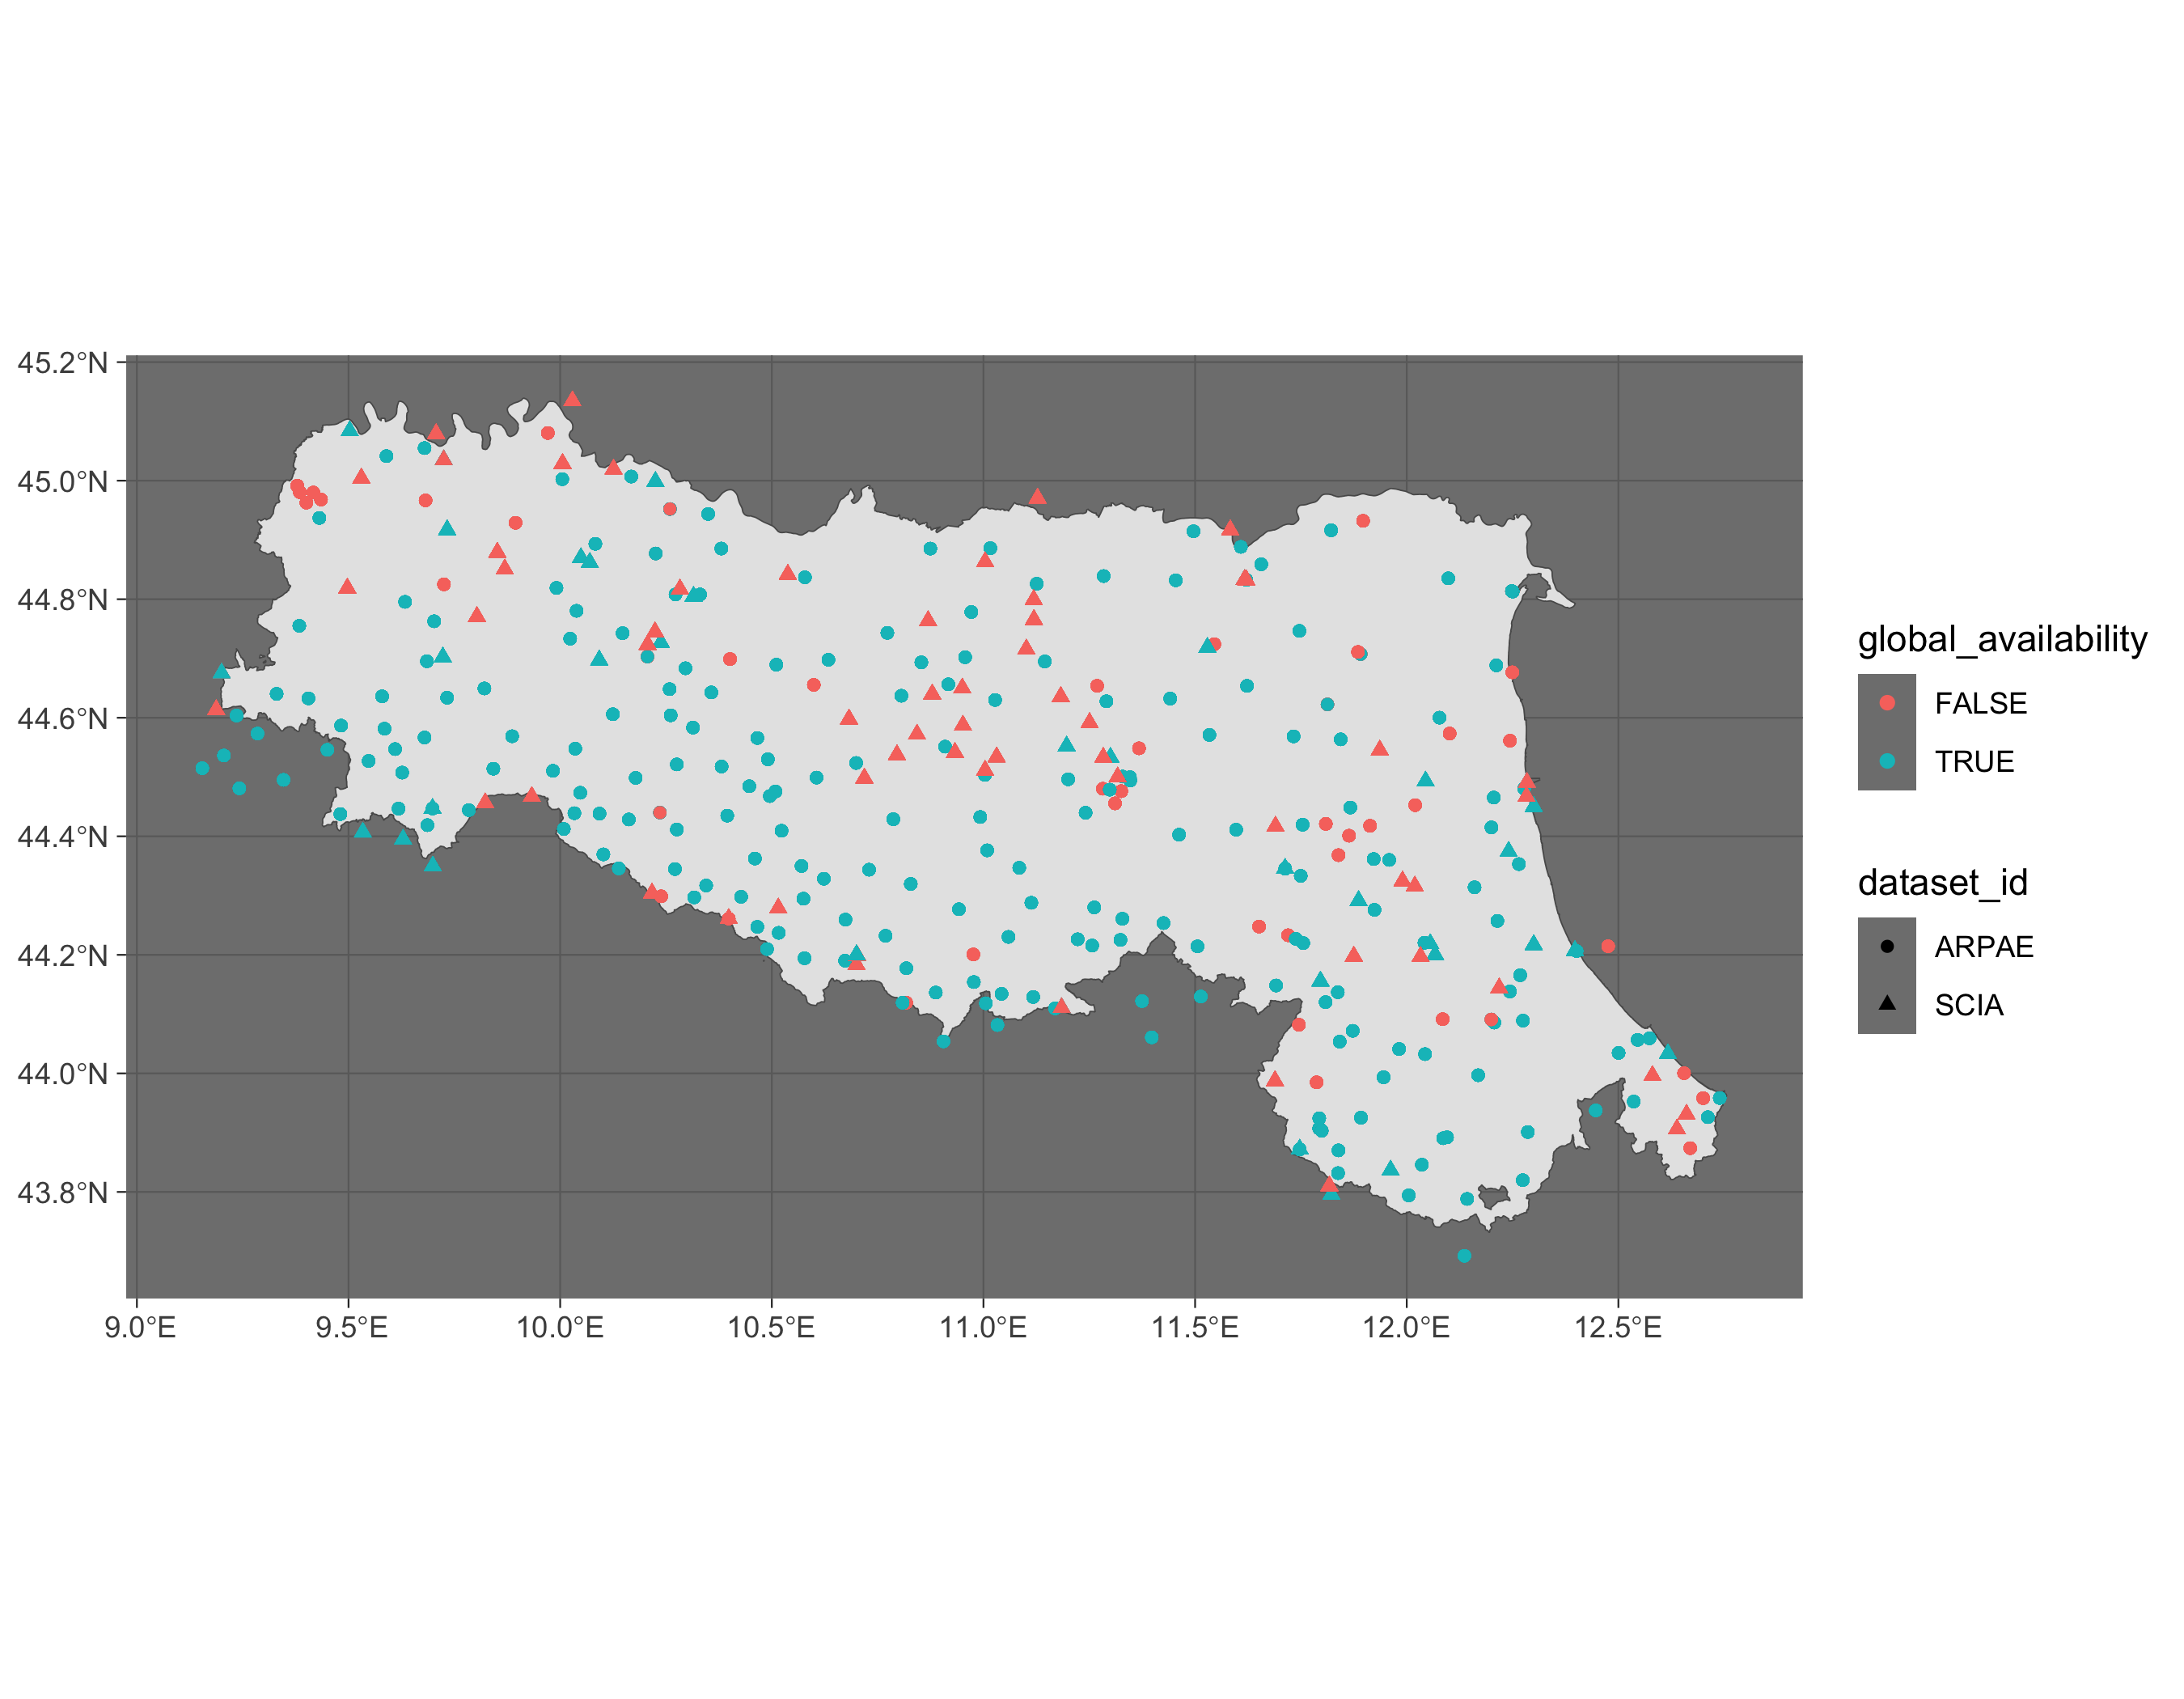

In [39]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [40]:
rm(ymonthly_avail)
rm(climats)
rm(combination_results)
rm(combined_database)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2408311,128.7,6227121,332.6,NA,6227121,332.6
Vcells,29958743,228.6,248188112,1893.6,16384,523709723,3995.6


### Merge interno

In [43]:
scia_merged <- open_checkpoint(dataset_id, "scia_merged")
analysis_results <- perform_analysis_single(
    scia_merged,
    dist_km = 8,
    first_date,
    last_date,
    file.path(str_to_lower(state), "internal.xlsx"),
)

rm(scia_merged)
gc()

Data prepared. Launching analysis...

Warning message in rm(qc_state):
"oggetto 'qc_state' non trovato"
Warning message in rm(qc_scia):
"oggetto 'qc_scia' non trovato"


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2407166,128.6,6227121,332.6,NA,6227121,332.6
Vcells,21254875,162.2,455878691,3478.1,16384,569848363,4347.6


In [49]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,622
FALSE,TRUE,1316
TRUE,FALSE,66
TRUE,TRUE,64


station_id.x,n
<chr>,<int>
7f8d7cc7e47d36bc45e45406d51a4c4b,1
9719bff2d476c2a8a811a99caa06d7d4,1
99ce3420516f4657fd1c76916c2a71ae,1
abbbc7146f5129d553798322f6699338,1
c769e66ce86f4f7c217b1ffd461aea9f,1
e6898e7dffb76b0db4fdd4a2a2d8d614,1


station_id.y,n
<chr>,<int>
425c3357a891464738fc350a6f245e06,4
66a9222a8b4c6f1bc1728af75231756e,4
6d86100c4fac184e1e048409ed6c4b16,4
7abed991b4ba1bd62aaca15435cf6237,4
7f8d7cc7e47d36bc45e45406d51a4c4b,1
87612ab37c00500d3250f51fdd40c85e,4
9719bff2d476c2a8a811a99caa06d7d4,1
99ce3420516f4657fd1c76916c2a71ae,1
9c2f604fc6ca47bdb08f32a2b9b7926c,4


In [53]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1.5, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2410573,128.8,6227121,332.6,NA,6227121,332.6
Vcells,22225249,169.6,364702953,2782.5,16384,569848363,4347.6


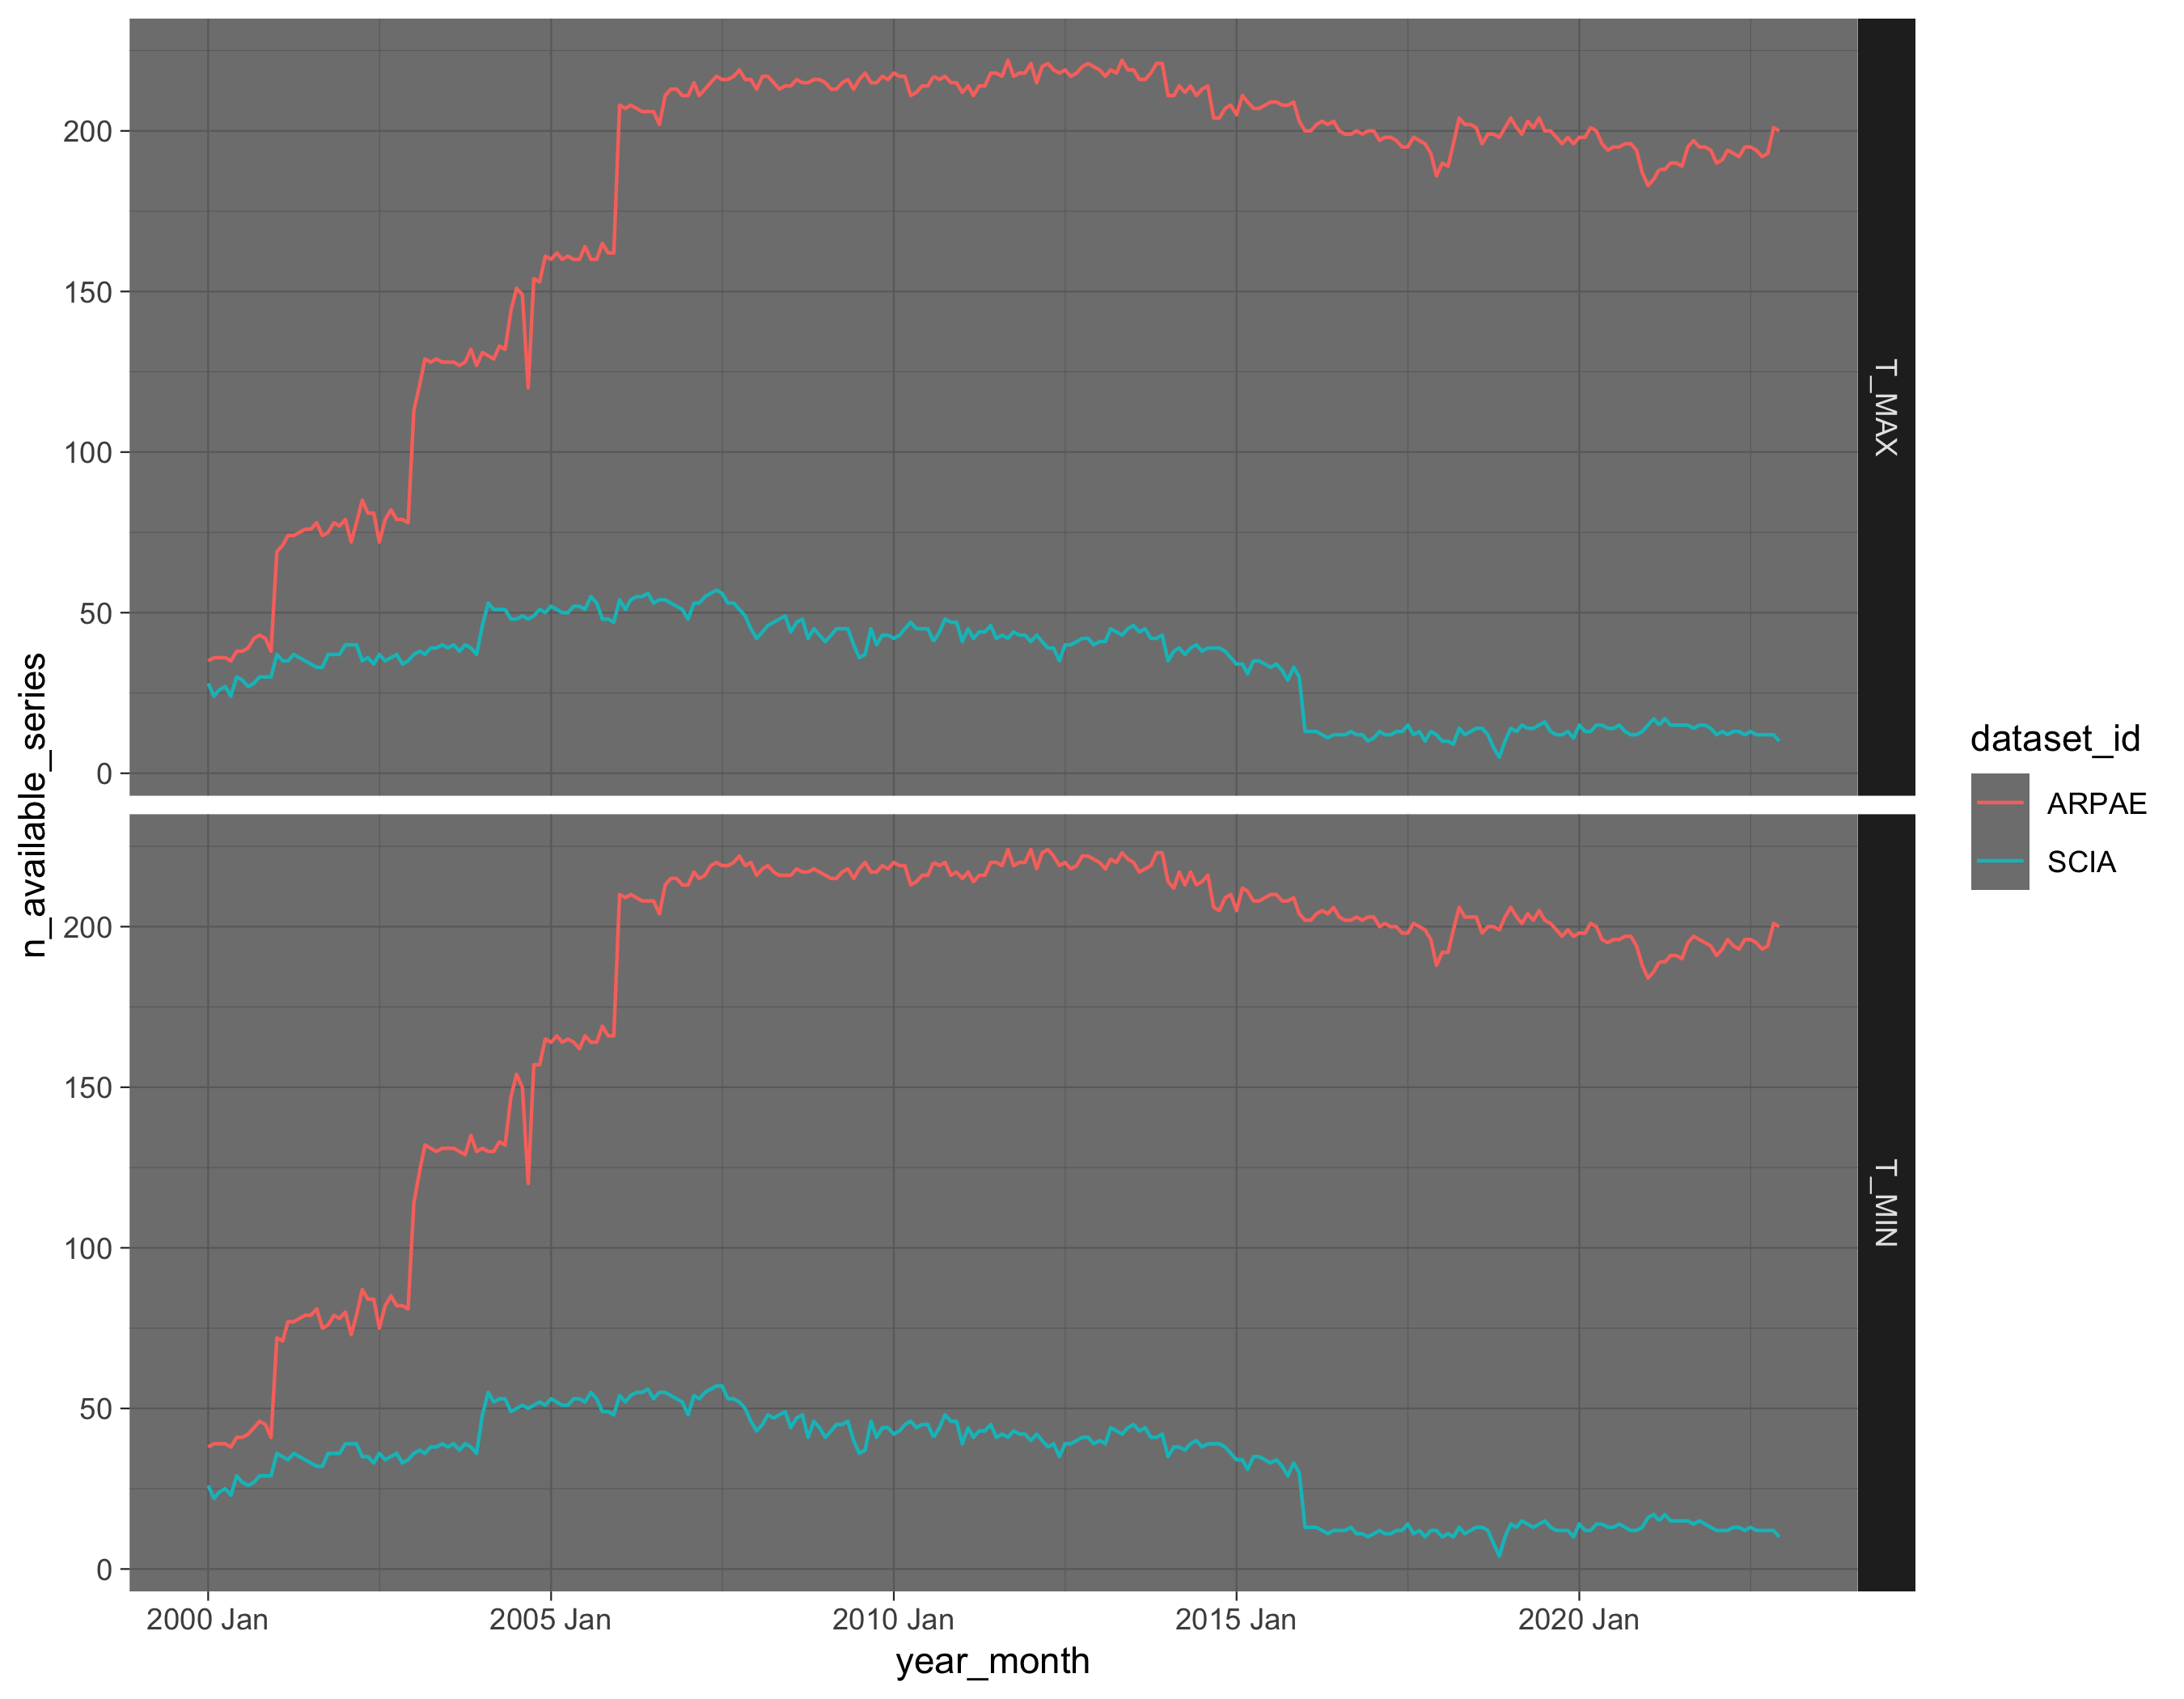

In [54]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


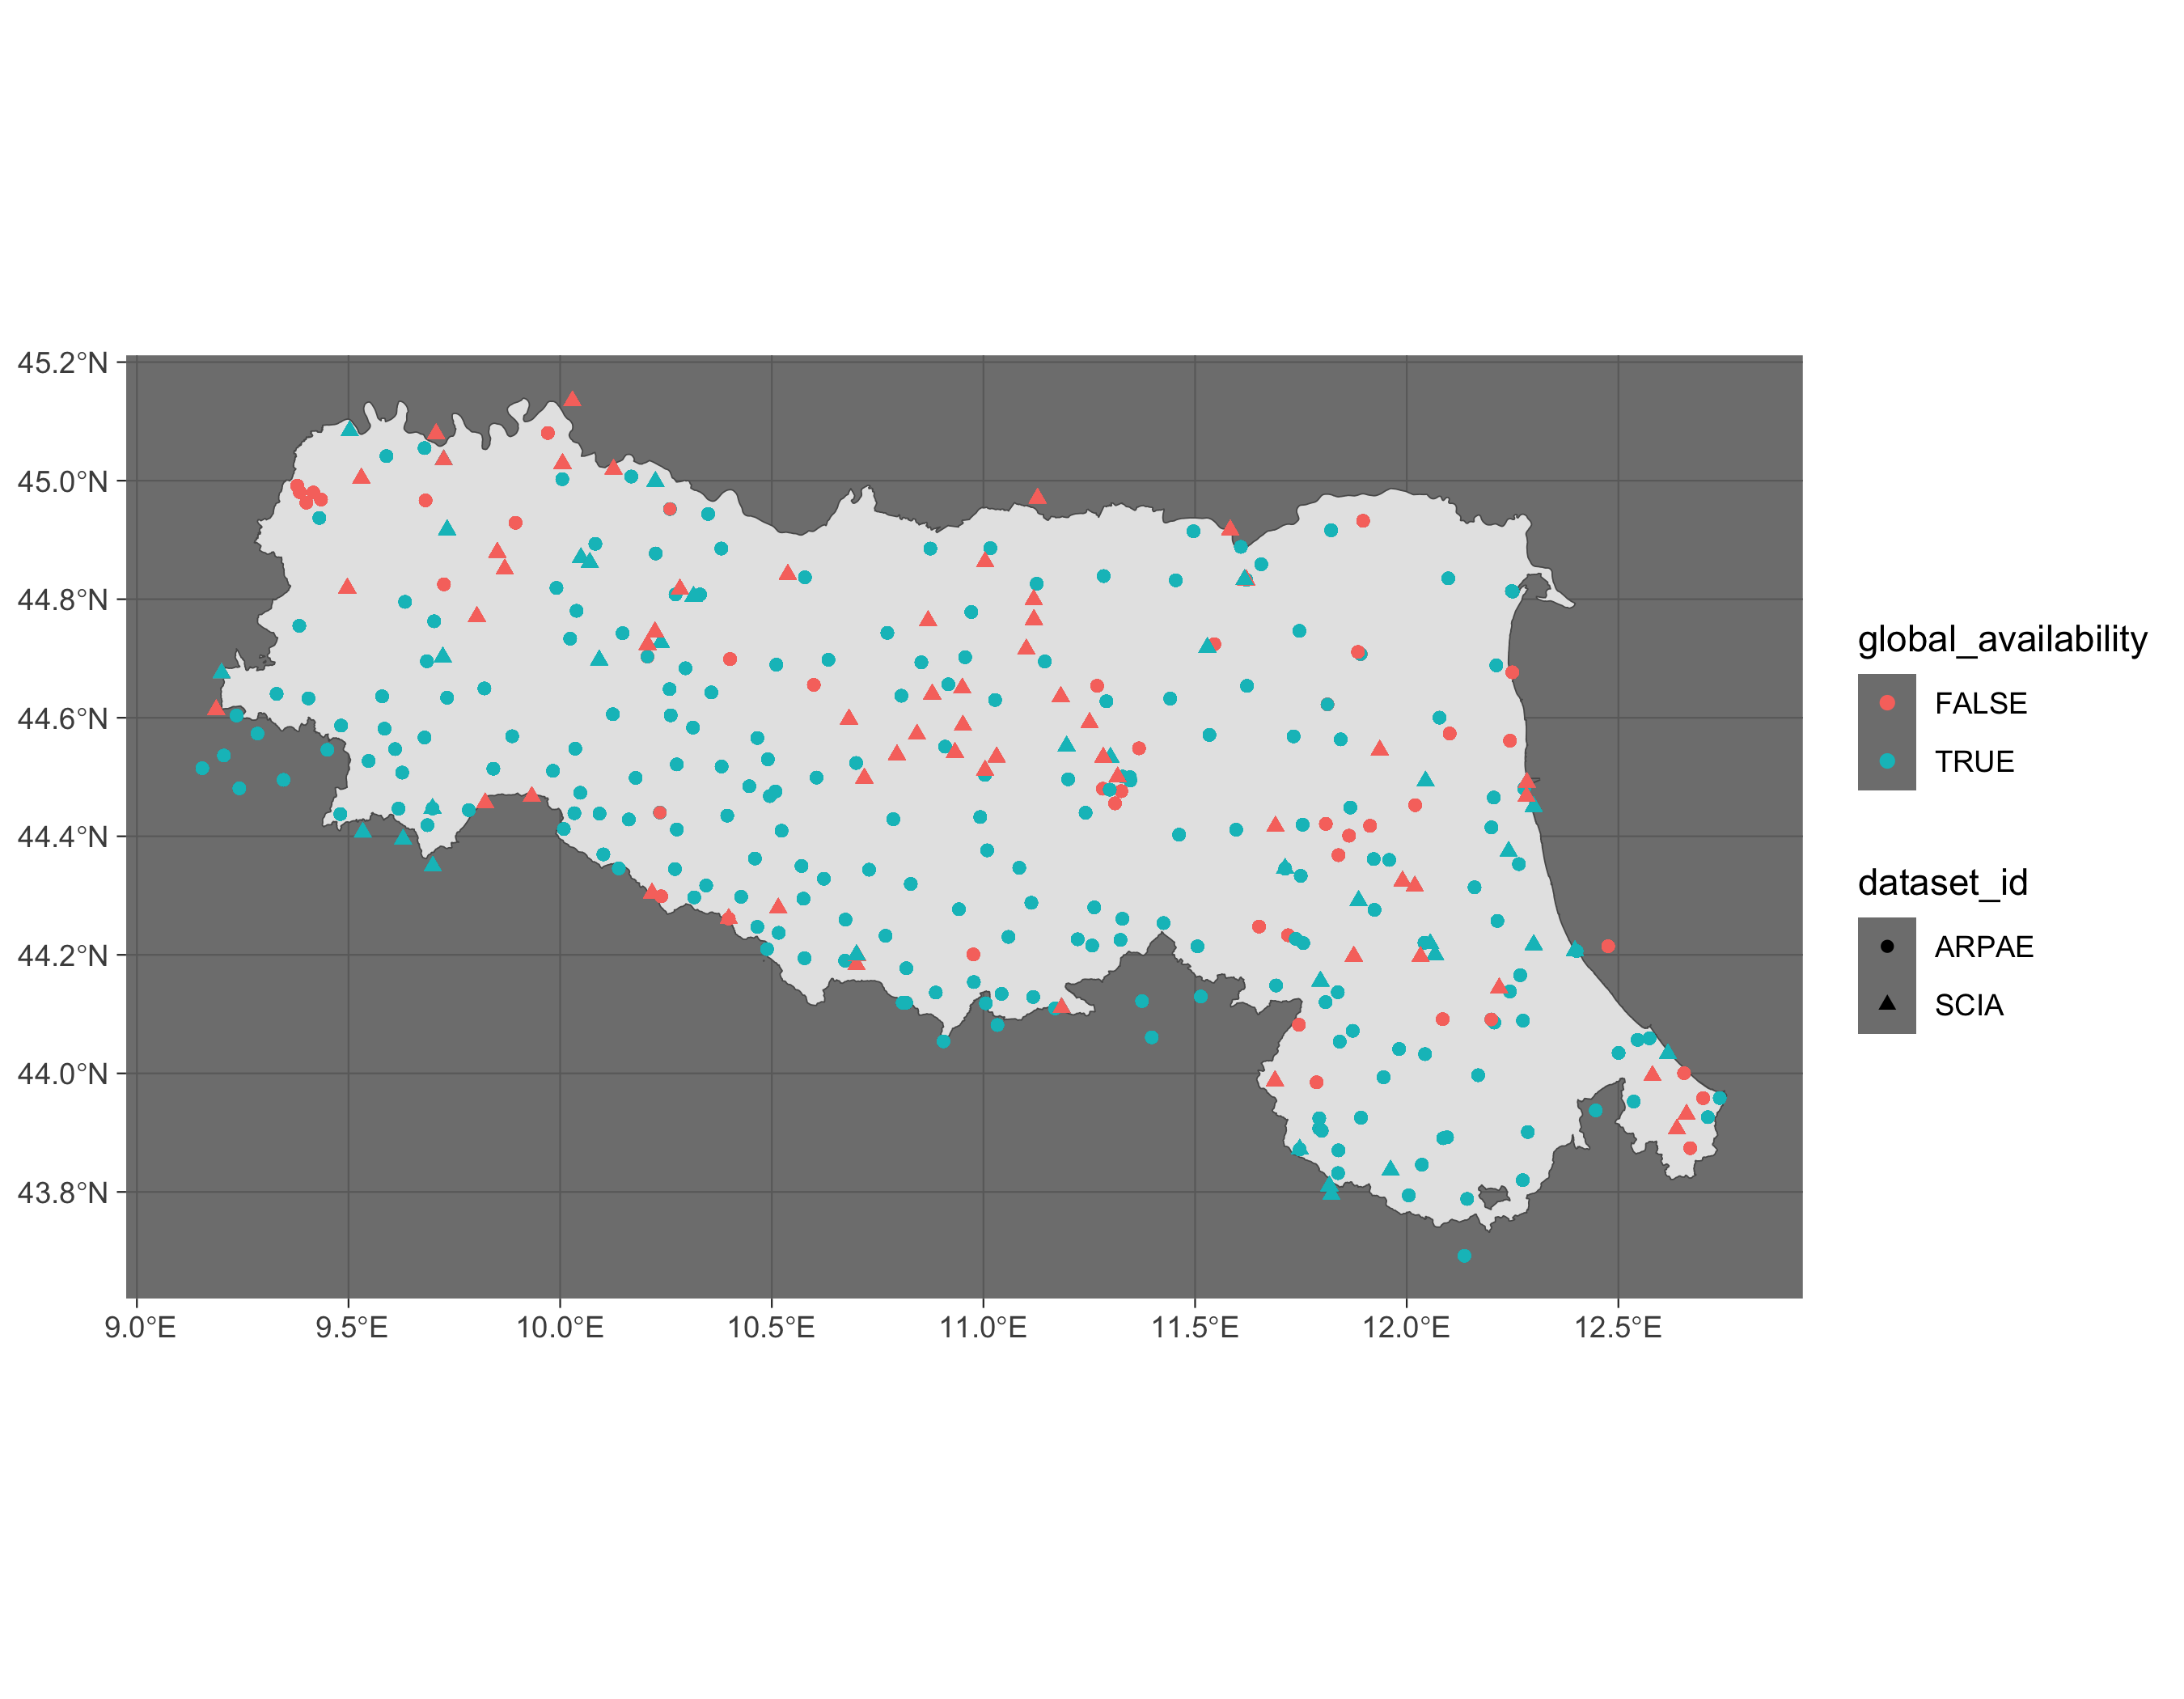

In [55]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [56]:
rm(ymonthly_avail)
rm(climats)
rm(combined_database)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2409367,128.7,6227121,332.6,NA,6227121,332.6
Vcells,21257047,162.2,291762363,2226.0,16384,569848363,4347.6


In [57]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |> distinct(station_id, variable) |> compute() |> nrow()

[1] 704

In [ ]:
# Lanciare da terminale
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(, "merged") |>
    launch_leaflet()